<br><br>
You Only Look Once
<br><br><br>

In [1]:
import cv2
import matplotlib.pyplot as plt
import utils

from darknet import Darknet

## 设置神经网络

我们将使用最新版本的YOLO，即YOLOv3。在`saved_models`下包含了需要的模型文件. 其中包含:

- `yolov3.cfg`: 包含YOLOv3使用的网络架构.
- `yolov3.weights`: 预训练权重文件. 
- `coco.names`: 包含权重训练中要检测的80个对象类的列表.

在下面的代码中，首先要规定包含神经网络架构文件、预训练的权重以及对象类的位置。然后就要使用*Darknet* 设置神经网络，具体要使用`cfg_file`中指定的网络架构。然后，使用`.load_weights()`方法将我们预训练的权重集加载到模型中。最后，使用`utils`模块中的`load_class_names()`函数来加载80个对象类。

In [3]:
# Set the location and name of the cfg file
cfg_file = './saved_models/yolov3.cfg'

# Set the location and name of the pre-trained weights file
weight_file = './saved_models/yolov3.weights'

# Set the location and name of the COCO object classes file
namesfile = './saved_models/coco.names'

# Load the network architecture
m = Darknet(cfg_file)

# Load the pre-trained weights
m.load_weights(weight_file)

# Load the COCO object classes
class_names = utils.load_class_names(namesfile)

In [4]:
# Print the neural network used in YOLOv3
m.print_network()

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32
    1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64
    2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32
    3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64
    4 shortcut 1
    5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128
    6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
    7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
    8 shortcut 5
    9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
   10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
   11 shortcut 8
   12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256
   13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128
   14 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
   15 shortcut 12
   16 conv    128  1 x 1

YOLOv3使用的神经网络主要由卷积层组成，有一些快捷连接层和上采样层。有关此网络的完整说明，请参阅这篇 <a href="https://pjreddie.com/media/files/papers/YOLOv3.pdf">YOLOv3 论文</a>.

## 加载并调整图像大小

在下面的代码中，我们使用OpenCV的`cv2.imread()`函数来加载我们的图像。因为，此函数将图像加载为BGR，而我们要将图像转换为RGB，以便可以使用正确的颜色显示它们。

正如我们在前一个单元格中看到的那样，该神经网络第一层的输入大小为416 x 416 x 3。由于图像大小不同，我们必须调整图像大小，使其与网络中第一层的输入大小兼容。在下面的代码中，我们使用OpenCV的`cv2.resize()`函数调整图像大小。然后，绘制原始图像和调整大小后的图像。

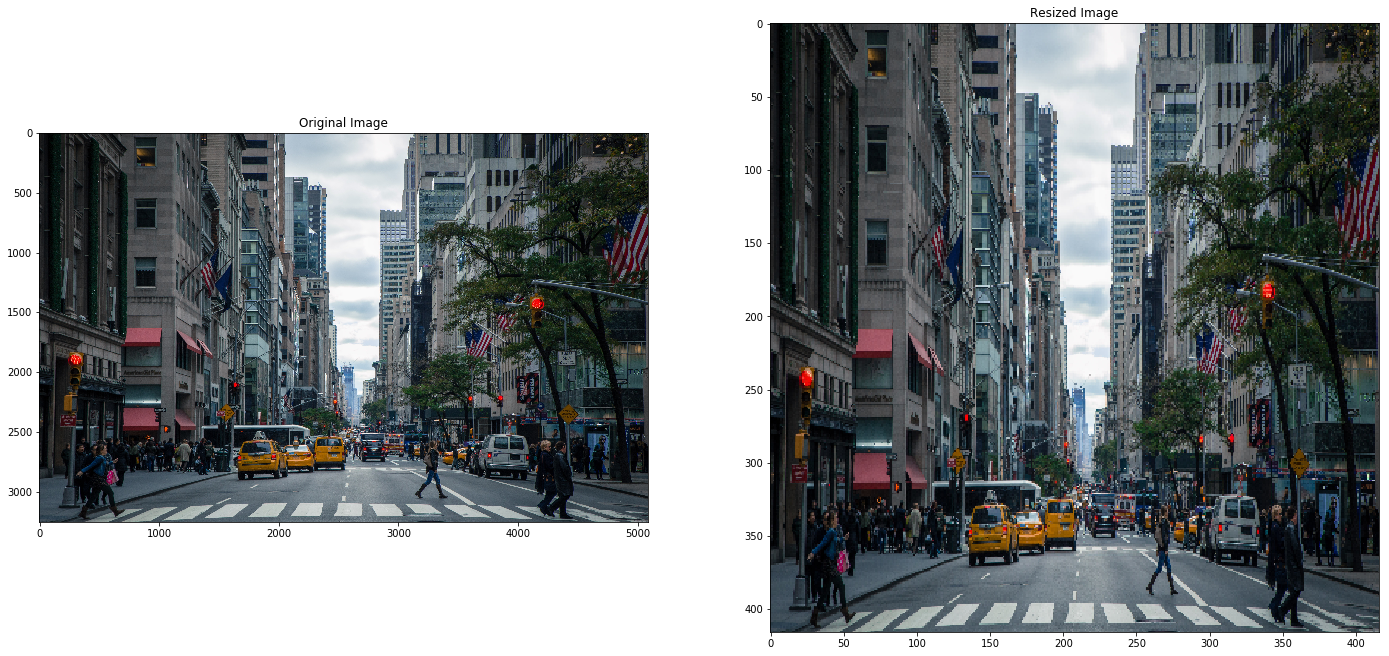

In [5]:
# 选一个你喜欢的图片吧!
image_path = './data/city_scene.jpg'

# Set the default figure size
plt.rcParams['figure.figsize'] = [24.0, 14.0]

# Load the image
img = cv2.imread(image_path)

# Convert the image to RGB
original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# We resize the image to the input width and height of the first layer of the network.    
resized_image = cv2.resize(original_image, (m.width, m.height))

# Display the images
plt.subplot(121)
plt.title('Original Image')
plt.imshow(original_image)
plt.subplot(122)
plt.title('Resized Image')
plt.imshow(resized_image)
plt.show()

## 设置非极大抑制阈值

YOLO使用**非极大值抑制（NMS）**来保留最佳边界框。NMS的第一步是删除检测概率小于给定NMS阈值的所有预测边界框。在下面的代码中，我们将此NMS阈值设置为0.6。这意味着将删除检测概率小于0.6的所有预测边界框。

In [6]:
# Set the NMS threshold
nms_thresh = 0.6

## 设置交并比（IOU）阈值

在删除所有具有低检测概率的预测边界框之后，NMS中的第二步是选择具有最高检测概率的边界框，并消除其**交并比（IOU）**值高于给定IOU阈值的所有边界框。 在下面的代码中，我们将此IOU阈值设置为`0.4`。这就是说，相对于最佳边界框来说， IOU值大于0.4的所有预测边界框将会被删除。

In [ ]:
# Set the IOU threshold
iou_thresh = 0.4

## 物体检测

图像被加载并调整大小，并且选定了`nms_thresh`和`iou_thresh`的参数之后，我们就可以使用YOLO算法来检测图像中的对象。我们要使用`utils`模块中的`detect_objects(m, resized_image, iou_thresh, nms_thresh)`函数来检测对象。此函数会接收*Darknet*返回的模型`m`、调整大小的图像以及NMS与IOU阈值作为输入，并返回检测到的对象的边界框。

每个边界框包含7个参数：边界框中心的坐标 *(x, y)*、边界框的宽度*w*和高度*h*、置信度检测级别、对象类概率以及对象类id。`detect_objects()`函数还会输出YOLO算法用于检测图像中的对象和检测到的对象数所花费的时间。由于我们是在CPU上运行该算法，因此检测到图像中的对象大约需要2秒钟，但是，如果使用GPU，它将运行得更快。

获得YOLO检测到的对象的边界框之后，就可以输出检测到的对象的类及其对应的对象类概率。为此，我们要用到`utils`模块中的`print_objects()`函数。

 最后，我们要使用`plot_boxes()`函数绘制YOLO在我们的图像中检测到的边界框和相应的对象类标签。如果将 `plot_labels`标记设置为`False`，则将显示没有标签的边界框。如果`nms_thresh` 值太低，可以更容易地查看边界框。 `plot_boxes()`函数会使用相同的颜色绘制同一对象类的边界框。但是，如果希望所有边界框都是相同的颜色，则可以使用`color` 关键字设置所需的颜色。例如，如果你希望所有边界框都是红色的，则可以使用：

`plot_boxes(original_image, boxes, class_names, plot_labels = True, color = (1,0,0))` 



It took 1.628 seconds to detect the objects in the image.

Number of Objects Detected: 28 

Objects Found and Confidence Level:

1. person: 0.999996
2. person: 1.000000
3. car: 0.707237
4. truck: 0.933031
5. car: 0.658086
6. truck: 0.666982
7. person: 1.000000
8. traffic light: 1.000000
9. person: 1.000000
10. car: 0.997369
11. bus: 0.998023
12. person: 1.000000
13. person: 1.000000
14. person: 1.000000
15. person: 1.000000
16. person: 1.000000
17. traffic light: 1.000000
18. traffic light: 1.000000
19. handbag: 0.997282
20. traffic light: 1.000000
21. car: 0.989741
22. traffic light: 1.000000
23. traffic light: 0.999999
24. person: 0.999999
25. truck: 0.715035
26. traffic light: 1.000000
27. person: 0.999993
28. person: 0.999996


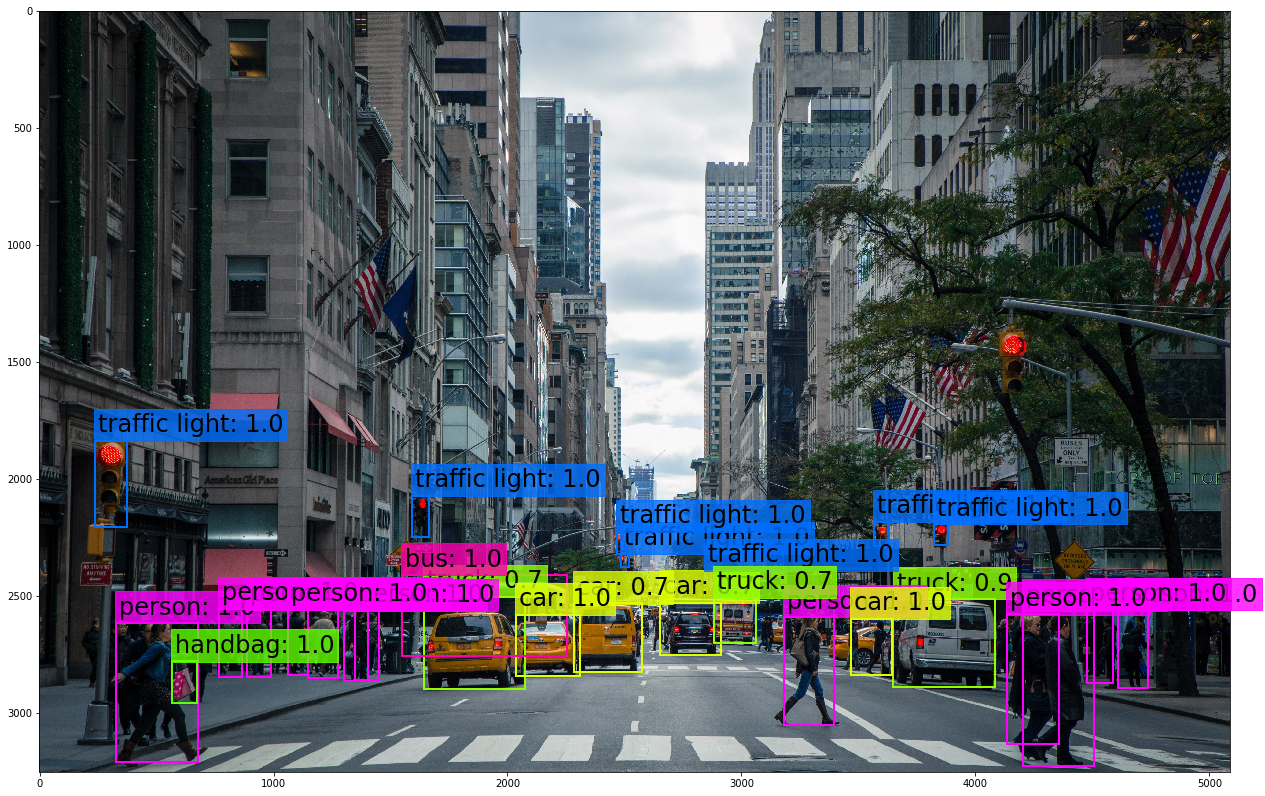

In [10]:
# Detect objects in the image
boxes = utils.detect_objects(m, resized_image, iou_thresh, nms_thresh)

# Print the objects found and the confidence level
utils.print_objects(boxes, class_names)

#Plot the image with bounding boxes and corresponding object class labels
utils.plot_boxes(original_image, boxes, class_names, plot_labels = True)